# Отчет о решении задачи "Mercari Price Suggestion Challenge"

### Селютин Вадим, 578 группа

Конкурс Kaggle: https://www.kaggle.com/c/mercari-price-suggestion-challenge

Иногда бывает довольно сложно угадать, сколько на самом деле стоит та или иная вещь. Даже маленькие детали могут иметь большое значение. Вычисление цены становится на порядок сложнее, когда речь идет об онлайн продажах. Например, на ценообразование одежды сильно влияет сезон, когда цены на электронику колеблются в зависимости от спецификации продукта. Целью данной задачи является предсказание цены товара, исходя из его описания, которое включает в себя название товара (name), его состояние (item_condition_id), категорию (category_name), название бренда (brand_name), цену (price), индикатор оплаты доставки товара покупателем или продавцом (shipping = {1,0}) и текстовое описание (item_description).

Подключим необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from nltk.corpus import stopwords
from nltk.tokenize import punkt
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sb

# Data analysis

Считаем предоставленные данные и посмотрим на несколько первых элементов.

In [65]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test_stg2.tsv', sep='\t')

In [66]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [67]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


Наборы данных содержат 3 дискретных признака (test_id/train_id, item_condition_id, shipping), 3 категориальных (name, category_name, item_descrition) и 1 вещественный (price).

Посмотрим на размер и тип входных данных.

In [68]:
print(train.shape)
print(test.shape)

(1482535, 8)
(3460725, 7)


In [69]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## Price

Рассмотрим целевую переменную price.

Средняя цена составляет примерно \$267, минимальная - \$0, а максимальная - \$2009.

In [70]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Видим, что распределение цен сильно смещено влево.

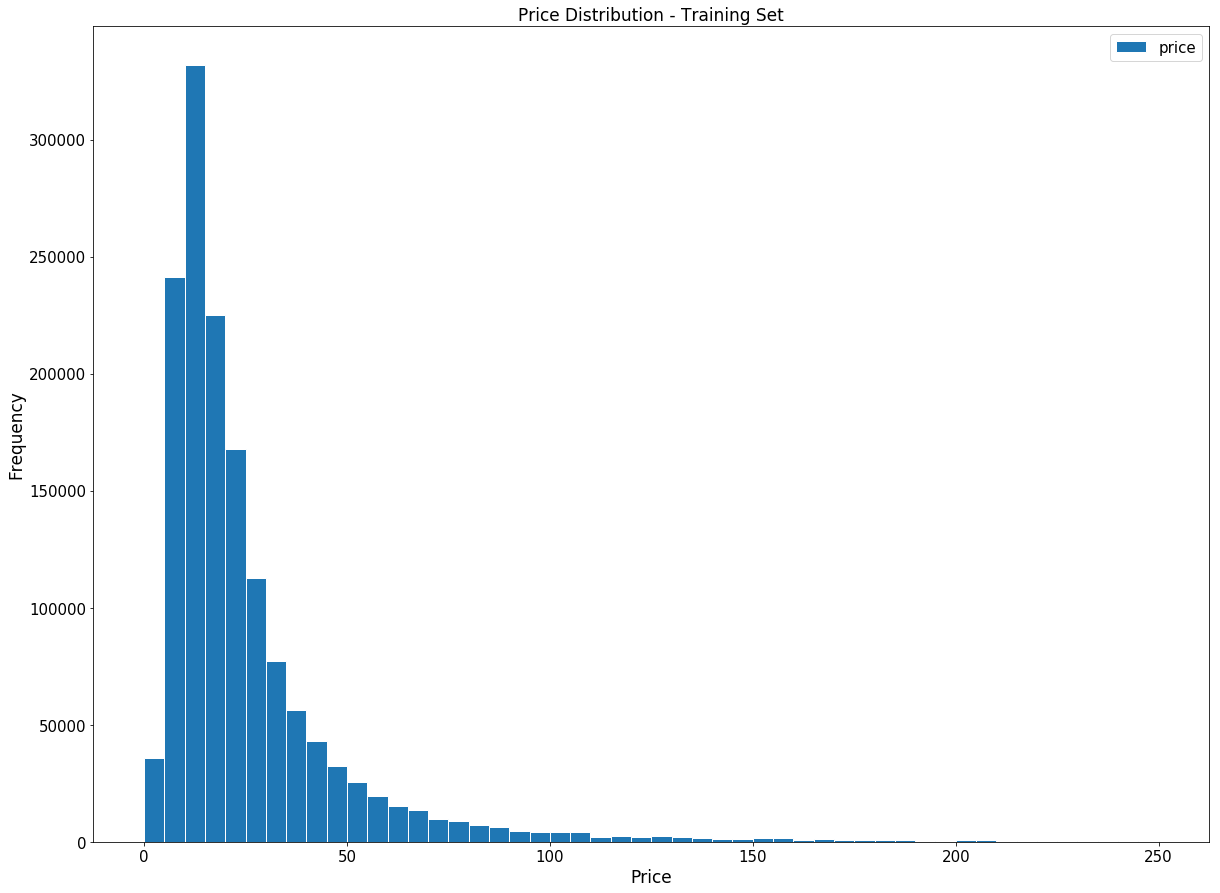

In [71]:
plt.figure(figsize=(20, 15))
plt.hist(train['price'], bins=50, range=[0,250], label='price', edgecolor='white')
plt.title('Price Distribution - Training Set', fontsize=17)
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Shipping

Больше половины всех перевозок товаров было оплачено продавцами.

In [72]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

Из распределения видно, что в среднем цена товара, когда покупатель сам оплачивает транспортировку, ниже цены, когда транспортировку оплачивает продавец.

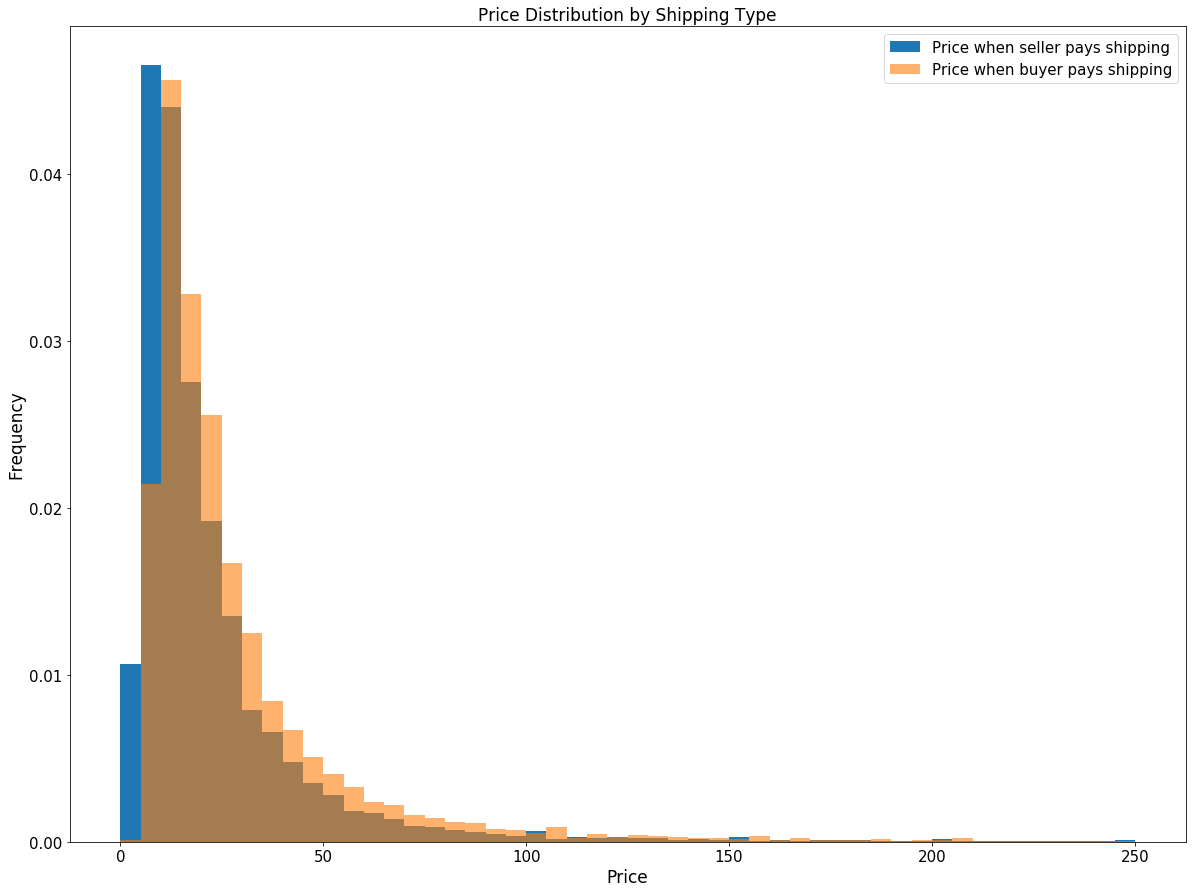

In [73]:
plt.figure(figsize=(20, 15))
plt.hist(train[train['shipping']==1]['price'], bins=50, normed=True, range=[0,250],
         alpha=1, label='Price when seller pays shipping')
plt.hist(train[train['shipping']==0]['price'], bins=50, normed=True, range=[0,250],
         alpha=0.6, label='Price when buyer pays shipping')
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Brand name

Количество брендов в обучающей и тестовой выборках составило 4809 и 3900 соответственно.

In [74]:
print("Number of unique brand names in train set = %d." % train['brand_name'].nunique())
print("Number of unique brand names in test set = %d." % test['brand_name'].nunique())

Number of unique brand names in train set = 4809.
Number of unique brand names in test set = 5860.


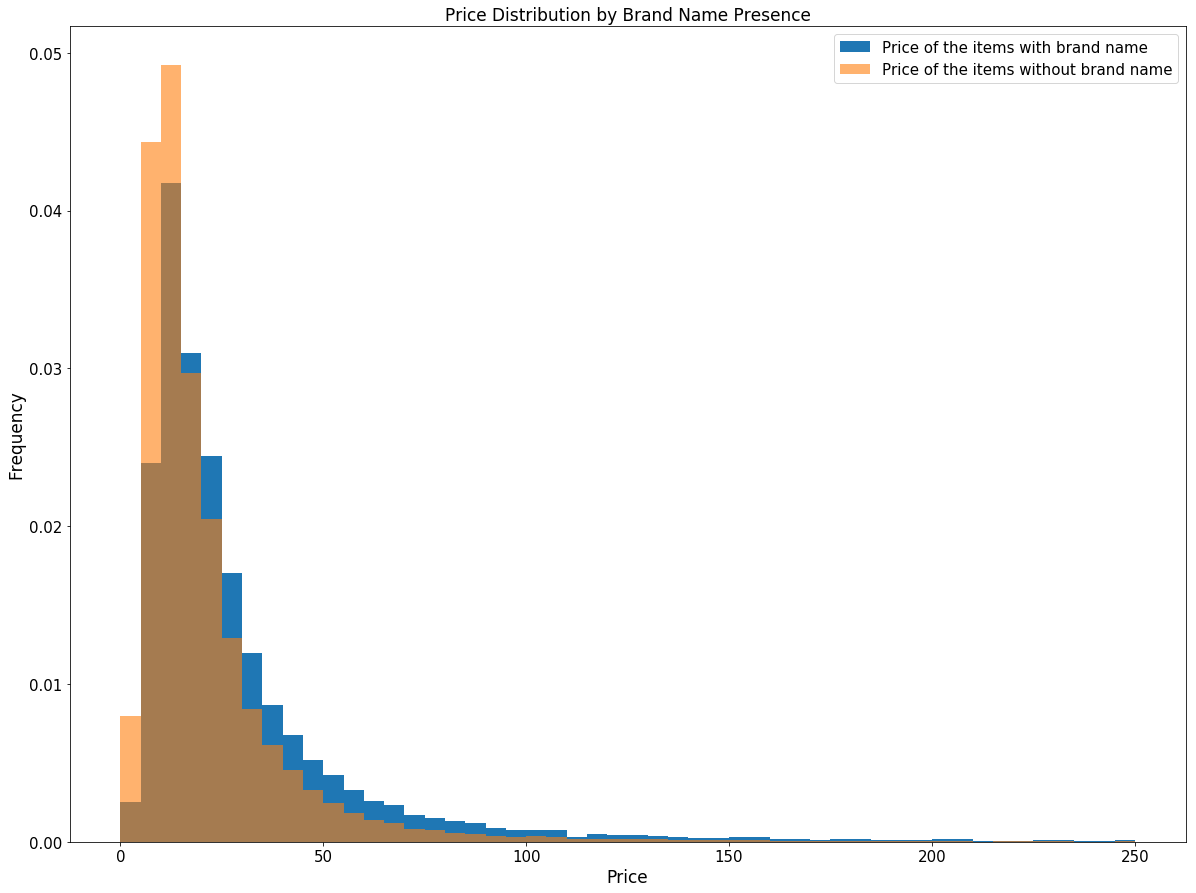

In [75]:
plt.figure(figsize=(20, 15))
plt.hist(train[train['brand_name']==train['brand_name']]['price'], bins=50, normed=True, range=[0,250],
         alpha=1, label='Price of the items with brand name')
plt.hist(train[train['brand_name']!=train['brand_name']]['price'], bins=50, normed=True, range=[0,250],
         alpha=0.6, label='Price of the items without brand name')
plt.title('Price Distribution by Brand Name Presence', fontsize=17)
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Item category

Всего в обучающей выборке 1287 категорий товаров, каждая из которых состоит из трех подкатегорий.

In [76]:
print("Number of unique category names = %d." % train['category_name'].nunique())

Number of unique category names = 1287.


Посмотрим на 5 наиболее часто встречающихся категорий.

In [77]:
print("Top 5 categories:")
train['category_name'].value_counts()[:5]

Top 5 categories:


Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

Разделим category_name на 3 подкатегории (general_cat, subcat_1, subcat_2) и добавим получившиеся значения к нашему набору данных. Для этого создадим функции split_category для разделения строки на подкатегории и subcat_function для применения split category к нашим данным и создания новых признаков.

In [78]:
def split_category(string):
    try: return string.split("/")
    except: return ("No Label", "No Label", "No Label")

In [79]:
def subcat_function(data):
    data = data.assign(general_cat=[split_category(cat)[0] for cat in data['category_name']])
    data = data.assign(subcat_1=[split_category(cat)[1] for cat in data['category_name']])
    data = data.assign(subcat_2=[split_category(cat)[2] for cat in data['category_name']])
    return data

In [80]:
train = subcat_function(train)
test = subcat_function(test)

Посмотрим на получившийся результат.

In [81]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


Найдем мощность множества каждой из получившихся подкатегорий.

In [83]:
print("Number of unique general categories = %d." % train['general_cat'].nunique())
print("Number of unique first subcategories = %d." % train['subcat_1'].nunique())
print("Number of unique second subcategories = %d." % train['subcat_2'].nunique())

Number of unique general categories = 11.
Number of unique first subcategories = 114.
Number of unique second subcategories = 871.


Посмотрим на количественное распределение первой подкатегории.

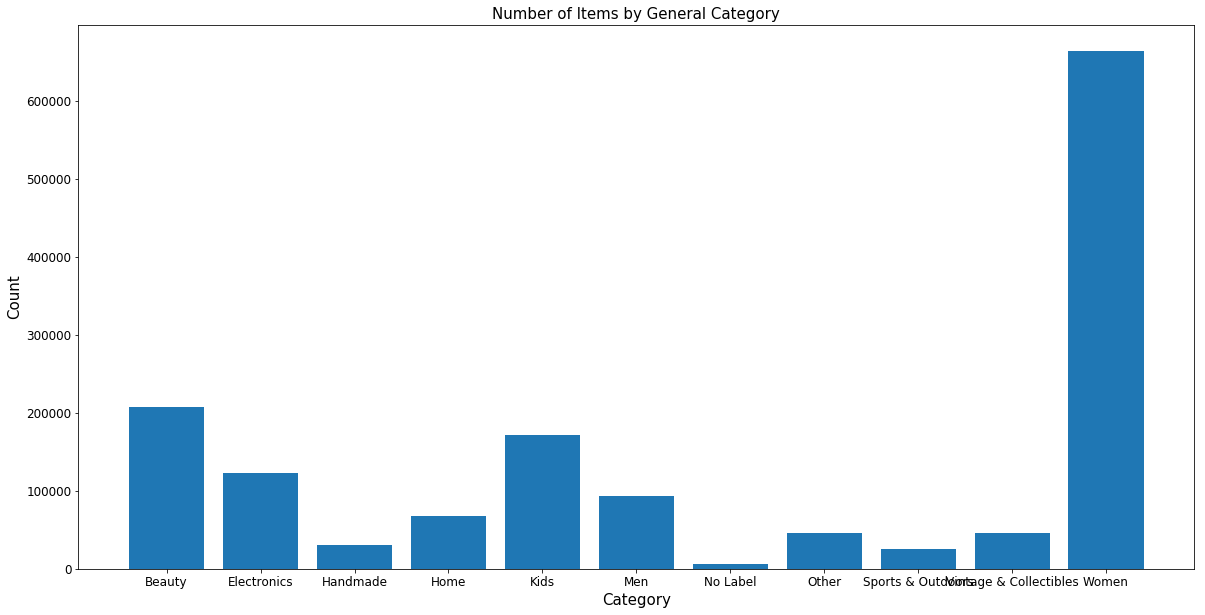

In [84]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
objects = set(train['general_cat'])

plt.figure(figsize=(20,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.title('Number of Items by General Category', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
 
plt.show()

Посмотрим на количественное распределение второй подкатегории, выбрав 15 наиболее встречающихся.

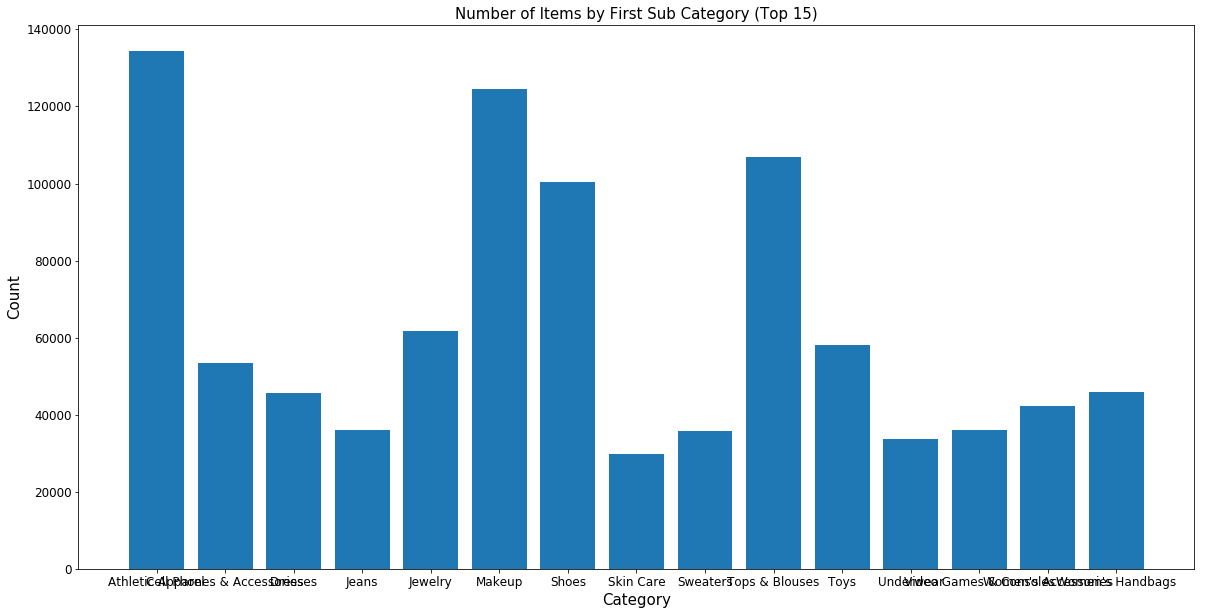

In [85]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
objects = set(train['general_cat'])

plt.figure(figsize=(20,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.title('Number of Items by First Sub Category (Top 15)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
 
plt.show()

Аналогично поступим c третьей подкатегорией товаров.

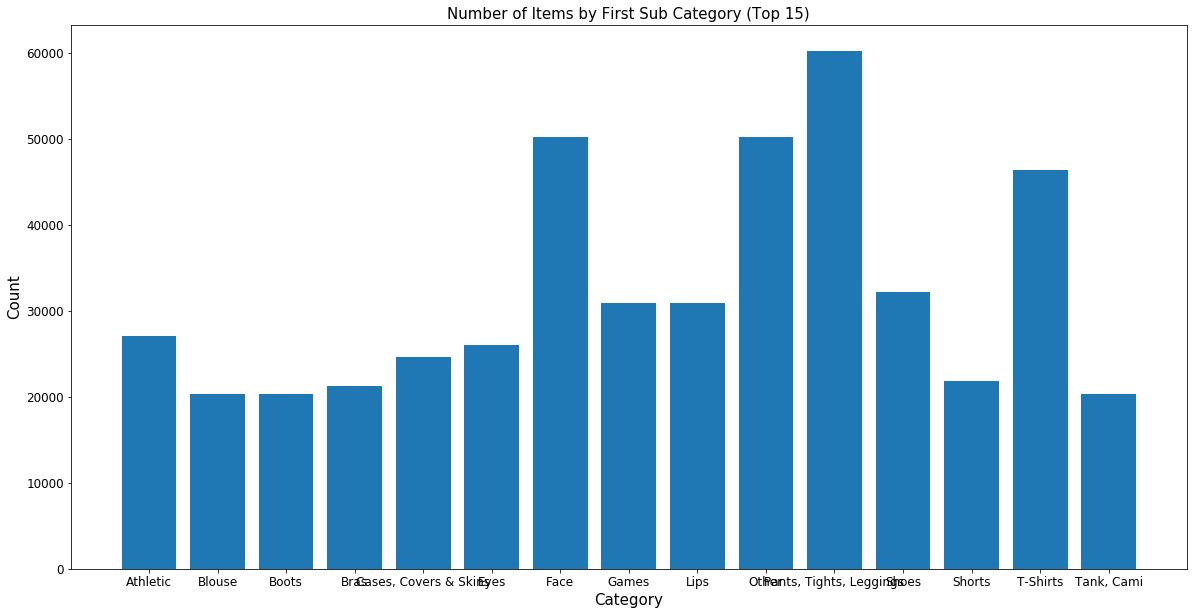

In [86]:
x = train['subcat_2'].value_counts().index.values.astype('str')[:15]
y = train['subcat_2'].value_counts().values[:15]
objects = set(train['general_cat'])

plt.figure(figsize=(20,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.title('Number of Items by First Sub Category (Top 15)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
 
plt.show()

## Item description

Как видно, по распределению нельзя точно сказать, влияет ли наличие описания товара на его цену.

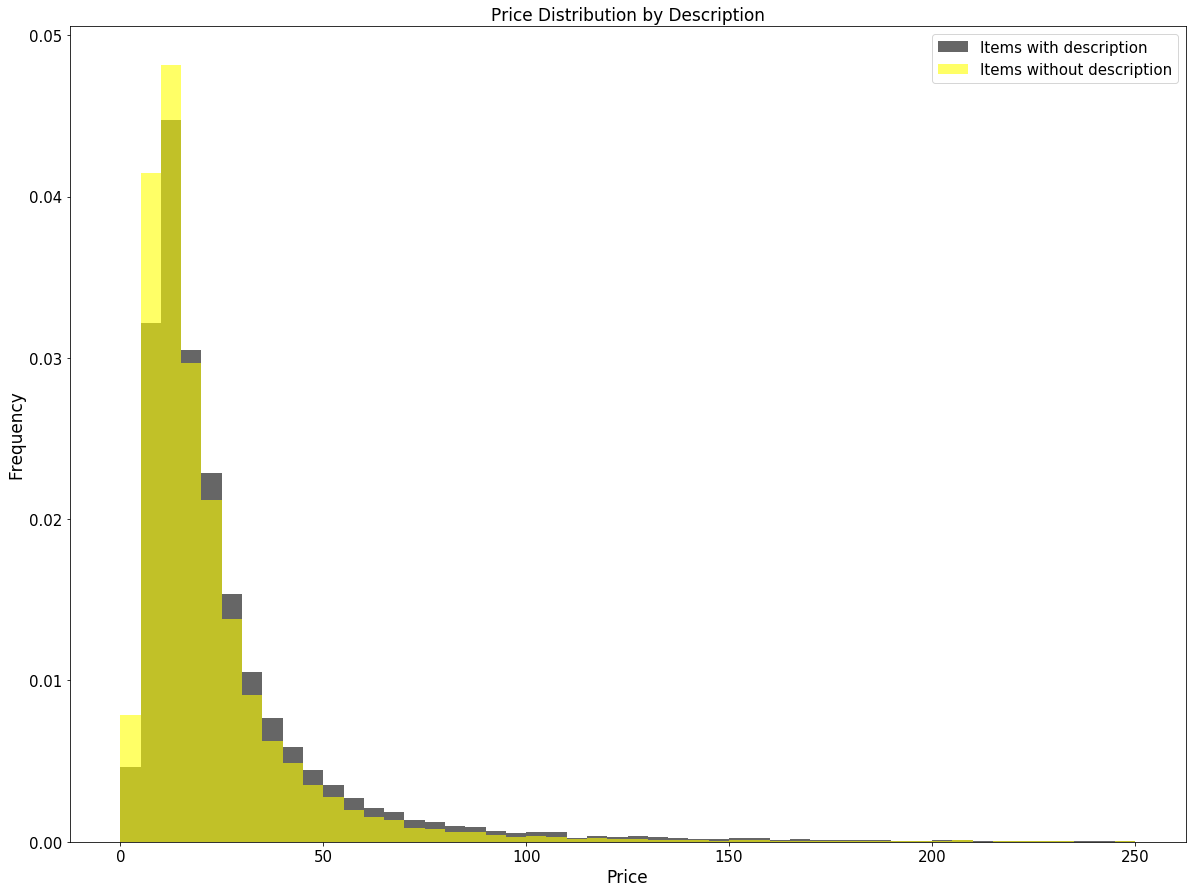

In [87]:
plt.figure(figsize=(20, 15))
bins=50
plt.hist(train[train['item_description']!='No description yet']['price'], bins, normed=True, range=[0,250], color='black',
         alpha=0.6, label='Items with description')
plt.hist(train[train['item_description']=='No description yet']['price'], bins, normed=True, range=[0,250], color='yellow',
         alpha=0.6, label='Items without description')
plt.title('Price Distribution by Description', fontsize=17)
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Feature engineering

Преобразуем исходные признаки, чтобы с ними можно было легче работать, проведем аккуратный feature engineering.

In [88]:
# Промежуточное сохранение результатов
train.to_csv('train_checkpoint.csv', index=False)
test.to_csv('test_checkpoint.csv', index=False)

### Description length

Введем новый признак - длину описания. При вычислении не будем учитывать общеупотребительные слова английского языка и слова, длина которых меньше 3. Для этого введем функцию descr_words_num, которая будет возвращать количество слов в описании товара, не учитывая пунктуацию и часто употребляемые слова.

In [89]:
def descr_words_num(descr):
    try:
        stop_words = set(stopwords.words('english'))
        descr = descr.lower()
        descr = ''.join(c for c in descr if c not in punctuation)
        word_tokens = word_tokenize(descr)
        filtered_sentence = [w for w in word_tokens if w not in stop_words and len(w)>3]
        return len(filtered_sentence)
    except:
        return 0

Создадим сам новый признак desc_len в обоих наборах данных.

In [90]:
train['desc_len'] = train['item_description'].apply(lambda x: descr_words_num(x))
test['desc_len'] = test['item_description'].apply(lambda x: descr_words_num(x))

Скопируем полученные результаты.

In [91]:
train_df = train.copy()
test_df = test.copy()

In [92]:
# Промежуточное сохранение результатов
train_df.to_csv('train_checkpoint.csv', index=False)
test_df.to_csv('test_checkpoint.csv', index=False)

### Category labels

Преобразуем категориальные признаки. Присвоим каждой подкатегории свой уникальный номер.

In [93]:
keys = list(train_df.general_cat.unique()) + list(test_df.general_cat.unique())
keys = list(set(keys))
values = list(range(len(keys)))
cat1_dict = dict(zip(keys, values))


keys = list(train_df.subcat_1.unique()) + list(test_df.subcat_1.unique())
keys = list(set(keys))
values = list(range(len(keys)))
cat2_dict = dict(zip(keys, values))


keys = list(train_df.subcat_2.unique()) + list(test_df.subcat_2.unique())
keys = list(set(keys))
values = list(range(len(keys)))
cat3_dict = dict(zip(keys, values))

In [94]:
def cat_label_for_row (row, cat1_dict = cat1_dict, cat2_dict = cat2_dict, cat3_dict = cat3_dict):
    cat1 = row['general_cat']
    cat2 = row['subcat_1']
    cat3 = row['subcat_2']
    return cat1_dict[cat1], cat2_dict[cat2], cat3_dict[cat3]


train_df["cat_1_label"], train_df["cat_2_label"], train_df["cat_3_lable"] = zip(*train_df.apply(lambda val: cat_label_for_row(val), axis =1))
test_df["cat_1_label"], test_df["cat_2_label"], test_df["cat_3_lable"] = zip(*test_df.apply(lambda val: cat_label_for_row(val), axis =1))

В дальнейшем сами названия подкатегорий нам не понадобятся, поэтому их можно удалить из наборов данных.

In [95]:
train_df = train_df.drop(columns=['category_name', 'general_cat', 'subcat_1', 'subcat_2'])
test_df = test_df.drop(columns=['category_name', 'general_cat', 'subcat_1', 'subcat_2'])

In [96]:
# Промежуточное сохранение результатов
train_df.to_csv('train_checkpoint.csv', index=False)
test_df.to_csv('test_checkpoint.csv', index=False)

### Brand labels

Аналогично поступаем и с названиями брендов. Присвоим каждому бренду уникальный номер, после чего удалим строковые названия брендов за ненадобностью.

In [97]:
keys = list(train_df.brand_name.unique()) + list(test_df.brand_name.unique())
keys = list(set(keys))
values = list(range(len(keys)))
brand_dict = dict(zip(keys, values))

In [98]:
train_df['brand_label'] = train_df.brand_name.apply(lambda row: brand_dict[row])
test_df['brand_label'] = test_df.brand_name.apply(lambda row: brand_dict[row])

In [99]:
train_df = train_df.drop(columns=['brand_name'])
test_df = test_df.drop(columns=['brand_name'])

Посмотрим на полученные признаки.

In [100]:
train_df.head()

,train_id,name,item_condition_id,price,shipping,item_description,desc_len,cat_1_label,cat_2_label,cat_3_lable,brand_label
0,0,MLB Cincinnati Reds T Shirt Size XL,3,10.0,1,No description yet,1,2,53,299,0
1,1,Razer BlackWidow Chroma Keyboard,3,52.0,0,This keyboard is in great condition and works ...,14,6,57,346,1933
2,2,AVA-VIV Blouse,1,10.0,1,Adorable top with a hint of lace and a key hol...,10,7,78,779,2235
3,3,Leather Horse Statues,1,35.0,1,New with tags. Leather horses. Retail for [rm]...,14,5,97,791,0
4,4,24K GOLD plated rose,1,44.0,0,Complete with certificate of authenticity,3,7,25,143,0


In [101]:
# Промежуточное сохранение результатов
train_df.to_csv('train_checkpoint.csv', index=False)
test_df.to_csv('test_checkpoint.csv', index=False)

### TF-IDF (item description)

Чтобы понять, как именно влияет описание товара на его цену, воспользуемся tf-idf обработкой описаний.

Сначала исключим объекты с пустым описанием.

In [3]:
print(train_df.shape[0])
train_df = train_df.loc[train_df.item_description == train_df.item_description]
test_df = test_df.loc[test_df.item_description == test_df.item_description]
print(train_df.shape[0])

1482535
1482531


Исключим из рассмотрения общеупотребительные слова и выражения длиннее 1 слова.

In [4]:
tfidf_vec = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1))

Получим tf-idf представление описаний товаров.

In [5]:
full_tfidf_descr = tfidf_vec.fit_transform(list(train_df['item_description'].values) + list(test_df['item_description'].values))
train_tfidf_descr = tfidf_vec.transform(list(train_df['item_description'].values))
test_tfidf_descr = tfidf_vec.transform(list(test_df['item_description'].values))

### SVD on TF-IDF (item description)

При помощи сингулярного разложения уменьшим размерность полученных данных до 40.

In [7]:
n_comp = 40

svd_1 = TruncatedSVD(n_components=n_comp)
svd_1.fit(full_tfidf_descr)

TruncatedSVD(algorithm='randomized', n_components=40, n_iter=5,
       random_state=None, tol=0.0)

Проверим, является ли разложение на 40 компонент оптимальным.

In [8]:
singular_values_ = svd_1.singular_values_
explained_variance_ratio_ = svd_1.explained_variance_ratio_

In [9]:
explained_variance_ratio_.sum()

0.2034639469009446

Разложение позволяет объяснить около 20% всей дисперсии.

In [10]:
def plot_scores(d_scores, label):
    n_components = np.arange(1,d_scores.size+1)
    plt.plot(n_components, d_scores, 'b', label=label)
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('explained variance')
    plt.legend(loc='lower right')

scores = list()
for d in range(1, 800):
    scores.append(explained_variance_ratio_[:d].sum())

Определим оптимальное количество компонент для разложения. Для этого посмотрим на разности в дисперсиях в отсортированном ряде $\lambda_{(1)} > \lambda_{(2)} > \dots > \lambda_{(D)}$: $\lambda_{(1)}-\lambda_{(2)}, \dots, \lambda_{(D-1)} - \lambda_{(D)}$.

1


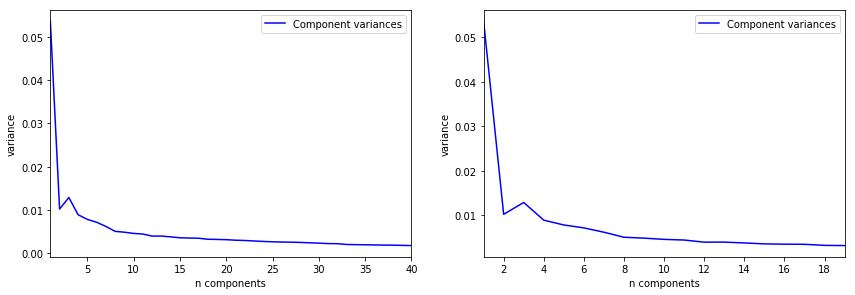

In [11]:
def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')

sorted_vars = explained_variance_ratio_
deltas = list()
for i in range(1, len(sorted_vars)):
    deltas.append(sorted_vars[i-1] - sorted_vars[i])
print(deltas.index(max(deltas))+1)
fig = plt.figure(figsize=(22,10))

plt.subplot(2, 3, 1)
plot_variances(np.array(sorted_vars))
plt.subplot(2, 3, 2)
plot_variances(np.array(sorted_vars[:19]))

Получили, что формально мы должны оставить всего одну компоненту - именно на ней наблюдается наибольший скачок. Но мы попробуем вариант с 6 компонентами, который из графика кажется более логичным.

In [12]:
svd_1 = TruncatedSVD(n_components=6)
svd_1.fit(full_tfidf_descr)

TruncatedSVD(algorithm='randomized', n_components=6, n_iter=5,
       random_state=None, tol=0.0)

Добавим данные значения к нашим наборам данных.

In [14]:
train_svd = pd.DataFrame(svd_1.transform(train_tfidf_descr))
test_svd = pd.DataFrame(svd_1.transform(test_tfidf_descr))

train_svd.columns = ['svd_item_'+str(i) for i in range(6)]
test_svd.columns = ['svd_item_'+str(i) for i in range(6)]

train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [15]:
# Промежуточное сохранение результатов
train_df.to_csv('train_checkpoint.csv', index=False)
test_df.to_csv('test_checkpoint.csv', index=False)

### TF-IDF (item name)

Абсолютно аналогично поступим и с названиями товаров.

Исключим объекты с пустым описанием.

In [16]:
print(train_df.shape[0])
train_df = train_df.loc[train_df.name == train_df.name]
test_df = test_df.loc[test_df.name == test_df.name]
print(train_df.shape[0])

1482535
1482531


Исключим из рассмотрения общеупотребительные слова и выражения длиннее 1 слова.

In [17]:
tfidf_vec = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1))

Получим tf-idf представление названий товаров.

In [18]:
full_tfidf_name = tfidf_vec.fit_transform(list(train_df['name'].values) + list(test_df['name'].values))
train_tfidf_name = tfidf_vec.transform(list(train_df['name'].values))
test_tfidf_name = tfidf_vec.transform(list(test_df['name'].values))

### SVD on TF-IDF (item name)

Уменьшим размерность до 40 значений.

In [19]:
n_comp = 40

svd_2 = TruncatedSVD(n_components=n_comp)
svd_2.fit(full_tfidf_name)

TruncatedSVD(algorithm='randomized', n_components=40, n_iter=5,
       random_state=None, tol=0.0)

Проверим, является ли разложение на 40 компонент оптимальным.

In [20]:
singular_values_ = svd_2.singular_values_
explained_variance_ratio_ = svd_2.explained_variance_ratio_

In [21]:
explained_variance_ratio_.sum()

0.1418486968038038

Разложение позволяет объяснить около 14% всей дисперсии.

In [22]:
scores = list()
for d in range(1, 800):
    scores.append(explained_variance_ratio_[:d].sum())

Определим оптимальное количество компонент для разложения.

3


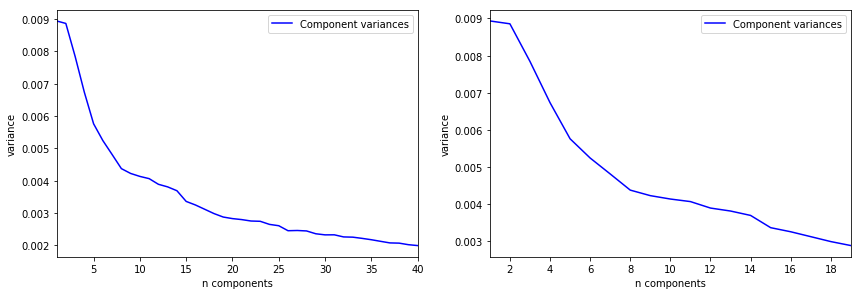

In [23]:
sorted_vars = explained_variance_ratio_
deltas = list()
for i in range(1, len(sorted_vars)):
    deltas.append(sorted_vars[i-1] - sorted_vars[i])
print(deltas.index(max(deltas))+1)
fig = plt.figure(figsize=(22,10))

plt.subplot(2, 3, 1)
plot_variances(np.array(sorted_vars))
plt.subplot(2, 3, 2)
plot_variances(np.array(sorted_vars[:19]))

Получили, что формально мы должны оставить 3 компоненты. Но мы попробуем вариант с 8 компонентами, который из графика кажется более логичным.

In [24]:
svd_2 = TruncatedSVD(n_components=8)
svd_2.fit(full_tfidf_name)

TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5,
       random_state=None, tol=0.0)

Добавим полученные значения к нашим наборам данных.

In [25]:
train_svd = pd.DataFrame(svd_2.transform(train_tfidf_name))
test_svd = pd.DataFrame(svd_2.transform(test_tfidf_name))

train_svd.columns = ['svd_name_'+str(i) for i in range(8)]
test_svd.columns = ['svd_name_'+str(i) for i in range(8)]

train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

Посмотрим на получившийся результат.

In [26]:
train_df.head()

,train_id,name,item_condition_id,price,shipping,item_description,desc_len,cat_1_label,cat_2_label,cat_3_lable,...,svd_item_4,svd_item_5,svd_name_0,svd_name_1,svd_name_2,svd_name_3,svd_name_4,svd_name_5,svd_name_6,svd_name_7
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3.0,10.0,1.0,No description yet,1.0,2.0,53.0,299.0,...,-0.000828,-0.000112,0.051447,0.029832,0.020830,-0.067094,0.126499,-0.027318,-0.099446,0.079905
1,1.0,Razer BlackWidow Chroma Keyboard,3.0,52.0,0.0,This keyboard is in great condition and works ...,14.0,6.0,57.0,346.0,...,-0.024268,0.007134,0.000072,0.000028,0.000046,-0.000113,0.000140,0.000704,0.000116,-0.000068
2,2.0,AVA-VIV Blouse,1.0,10.0,1.0,Adorable top with a hint of lace and a key hol...,10.0,7.0,78.0,779.0,...,0.033830,-0.007676,0.001766,0.001049,0.001459,-0.002691,0.004351,0.001041,-0.005911,-0.000358
3,3.0,Leather Horse Statues,1.0,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,14.0,5.0,97.0,791.0,...,0.174835,0.068481,0.002450,0.001945,0.000820,-0.003679,0.007046,0.006145,-0.007749,-0.006576
4,4.0,24K GOLD plated rose,1.0,44.0,0.0,Complete with certificate of authenticity,3.0,7.0,25.0,143.0,...,0.003313,0.001375,0.005634,0.005312,0.001977,-0.006590,0.009280,0.030234,-0.005529,-0.004299


In [27]:
# Промежуточное сохранение результатов
train_df.to_csv('train_checkpoint.csv', index=False)
test_df.to_csv('test_checkpoint.csv', index=False)

### Final data sets

Мы видим, что в итоге количество признаков в тестовой выборке превышает таковое в обучающей на единицу - признак price. Значит, данные были обработаны корректно.

In [28]:
print(train_df.shape[1])
print(test_df.shape[1])

25
24


In [29]:
train_final = train_df.copy()
test_final = test_df.copy()

Избавимся от более не нужных признаков (train_id/test_id, name, item_description), заполним пустые значения в наборах данных и сохраним результаты в отдельные файлы.

In [30]:
train_final = train_final.drop(columns=['train_id', 'name', 'item_description'])
test_final = test_final.drop(columns=['test_id', 'name', 'item_description'])

In [31]:
train_final.fillna(0, inplace=True)
test_final.fillna(0, inplace=True)

In [32]:
train_final.to_csv('train_final.csv', index=False)
test_final.to_csv('test_final.csv', index=False)

После обработки количество признаков для обучения стало равным 22.

In [33]:
train_final.head()

,item_condition_id,price,shipping,desc_len,cat_1_label,cat_2_label,cat_3_lable,brand_label,svd_item_0,svd_item_1,...,svd_item_4,svd_item_5,svd_name_0,svd_name_1,svd_name_2,svd_name_3,svd_name_4,svd_name_5,svd_name_6,svd_name_7
0,3.0,10.0,1.0,1.0,2.0,53.0,299.0,0.0,0.999997,-0.001772,...,-0.000828,-0.000112,0.051447,0.029832,0.020830,-0.067094,0.126499,-0.027318,-0.099446,0.079905
1,3.0,52.0,0.0,14.0,6.0,57.0,346.0,1933.0,0.000138,0.068283,...,-0.024268,0.007134,0.000072,0.000028,0.000046,-0.000113,0.000140,0.000704,0.000116,-0.000068
2,1.0,10.0,1.0,10.0,7.0,78.0,779.0,2235.0,0.000129,0.037782,...,0.033830,-0.007676,0.001766,0.001049,0.001459,-0.002691,0.004351,0.001041,-0.005911,-0.000358
3,1.0,35.0,1.0,14.0,5.0,97.0,791.0,0.0,0.000498,0.174783,...,0.174835,0.068481,0.002450,0.001945,0.000820,-0.003679,0.007046,0.006145,-0.007749,-0.006576
4,1.0,44.0,0.0,3.0,7.0,25.0,143.0,0.0,0.000018,0.002647,...,0.003313,0.001375,0.005634,0.005312,0.001977,-0.006590,0.009280,0.030234,-0.005529,-0.004299


# Построение моделей

Теперь наши данные готовы для работы.

In [2]:
import io
from sklearn.model_selection import train_test_split

Введем функцию ошибки.

In [3]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

Загрузим обработанные данные.

In [4]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

Разделим первый набор данных на выборку для обучения и выборку для валидации.

In [5]:
y = np.log(train['price'].values + 1)
X = train.drop(columns=['price']).values

(X_train, X_valid, y_train, y_valid) = train_test_split(X, y, test_size=0.3, shuffle=True)

Выделим тестовую выборку.

In [6]:
X_test = test.values

## Baseline solution

В качестве наивного baseline решения рассмотрим несколько линейных регрессоров без настройки параметров. Это не займет много времени и принесет вполне удовлетворительный результат.

### Linear Regression

Kaggle score: 0.52938

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Посмотрим, какой результат покажет данная модель на выборке для валидации.

In [17]:
y_test = lr_model.predict(X_test)

Запишем результаты на тестовой выборке в отдельный файл для отправки на Kaggle.

In [33]:
submission = pd.DataFrame(columns=['test_id', 'price'])
submission['test_id'] = [i for i in range(len(y_test))]
submission['price'] = np.exp(y_test) - 1
submission.to_csv('linear_reg_mercari_submission.csv', index=False)

### Lasso Regression

Kaggle score: 0.54275

Теперь построим модели с регуляризаторами. Возможно, они помогут нам решить проблему мультиколлинеарности.

In [19]:
from sklearn.linear_model import Lasso

In [21]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
y_test = lasso_model.predict(X_test)

In [24]:
submission = pd.DataFrame(columns=['test_id', 'price'])
submission['test_id'] = [i for i in range(len(y_test))]
submission['price'] = np.exp(y_test) - 1
submission.to_csv('lasso_mercari_submission.csv', index=False)

### Ridge Regression

Kaggle score: 0.50797

In [25]:
from sklearn.linear_model import Ridge

In [26]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [31]:
y_test = ridge_model.predict(X_test)

In [32]:
submission = pd.DataFrame(columns=['test_id', 'price'])
submission['test_id'] = [i for i in range(len(y_test))]
submission['price'] = np.exp(y_test) - 1
submission.to_csv('ridge_mercari_submission.csv', index=False)

Оценим качество построенных моделей методов кросс-валидации, разбив выборку на 3 фолда.

In [37]:
print 'Linear Regression score:',abs(cross_val_score(lr_model, X_valid, y_valid, scoring='neg_mean_squared_error').mean())
print 'Lasso Regression score:',abs(cross_val_score(lasso_model, X_valid, y_valid, scoring='neg_mean_squared_error').mean())
print 'Ridge Regression score:',abs(cross_val_score(ridge_model, X_valid, y_valid, scoring='neg_mean_squared_error').mean())

Linear Regression score: 0.50686358844
Lasso Regression score: 0.539636138827
Ridge Regression score: 0.506863574831


Как видно, введение регуляризаторов было хорошей идеей и лучший результат среди линейных моделей показал именно Ridge Regressor. Данная тенденция наблюдается как на выборке для валидации, так и на тестовой выборке.

## XGBoost

Kaggle score: 0.58861

В качестве кандидата на основное решение возьмем бустинг над решающими деревьями и сравним его с линейными моделями. Мы не будем строить случайный лес, поскольку обучение займет слишком много времени.

In [7]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Проведем осознанный последовательный подбор параметров с целью получения наименьшего значения ошибки.

In [9]:
xgb_par = {'min_child_weight': 20, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 5,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [10]:
xgb_model = xgb.train(xgb_par, dtrain, 100, watchlist, early_stopping_rounds=20, maximize=False, verbose_eval=20)

[0]	train-rmse:2.46929	valid-rmse:2.46641
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[20]	train-rmse:1.04817	valid-rmse:1.04964
[40]	train-rmse:0.635413	valid-rmse:0.653124
[60]	train-rmse:0.538394	valid-rmse:0.572496
[80]	train-rmse:0.506957	valid-rmse:0.553227
[99]	train-rmse:0.49143	valid-rmse:0.547367


In [11]:
y_test = xgb_model.predict(dtest)

In [12]:
submission = pd.DataFrame(columns=['test_id', 'price'])
submission['test_id'] = [i for i in range(len(y_test))]
submission['price'] = np.exp(y_test) - 1
submission.to_csv('xgboost_mercari_submission.csv', index=False)

По сравнению с простыми линейными регрессорами, xgboost показал более плохой результат. Вероятно, это связано с тем фактом, что бустинг не может уловить сложные зависимости между частотами вхождений слов и их комбинациями.

# Выводы

При решении данной задачи мы провели подробный анализ данных и преобразовали категориальные признаки. Названиям брендов и категорий были присвоены уникальные индексы, а описания товаров и их названия были преобразованы при помощи tf-idf. Для сокращения размерности полученных данных мы использовали SVD разложение с последующим выбором оптимального количества компонент. Данный метод довольно эффективен, но появляется возможность потери информации.

Для прогнозирования значений цены на тестовой выборке были построены следующие модели: Linear Regressor, Lasso Regressor, Ridge Regressor, XGBoost. Наименьшее значение ошибки 0.50797 было получено при помощи линейного регрессора с $L_2$-регуляризацией. Применение сложной модели бустинга над решающими деревьями с настройкой параметров не дало выигрыша.

Для дальнейшего улучшения полученных результатов можно рассмотреть подход, когда название товара и его описание рассматриваются в совокупности друг с другом, т.е. эти два признака объединяются. Также предлагается больше внимания уделить категориям товаров, назначая близкие по значению цены товарам, оказавшимся в одной категории.